In [1]:
from src.consts import IN_COLAB, DATASET_MAX_BOUNDING_BOX, DESIRE_BOUNDING_BOX_SIZE

if IN_COLAB:
    print('Found Google Colab')
    !pip3 install torch torchvision torchsummary
    !pip3 install simpleitk

    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

import matplotlib.pyplot as plt
import torch
import numpy as np

import src.dataset.oars_labels_consts as OARS_LABELS
from src.helpers.threshold_calc_helpers import get_threshold_info_df
from src.helpers.show_model_dataset_pred_preview import show_model_dataset_pred_preview
from src.dataset.dataset_cut_helpers import get_full_res_cut, get_cut_lists
from src.dataset.get_dataset import get_dataset
from src.dataset.get_dataset_info import get_dataset_info
from src.dataset.preview_dataset import preview_dataset
from src.model_and_training.prepare_model import prepare_model
from src.model_and_training.train_loop import train_loop
from src.model_and_training.training_helpers import show_model_info
from src.helpers.show_cuda_usage import show_cuda_usage
from src.helpers.threshold_calc_helpers import get_rescaled_preds
from src.dataset.split_dataset import split_dataset, copy_split_dataset
from src.helpers.compare_prediction_with_ground_true import compare_prediction_with_ground_true

from operator import itemgetter
from IPython.display import display, Markdown
from ipywidgets import widgets

torch.manual_seed(20)

print('Dataset biggest bounding box wihtout spinal cord', DATASET_MAX_BOUNDING_BOX)
print('Cut target size', DESIRE_BOUNDING_BOX_SIZE)
print('Done Init')

Dataset biggest bounding box wihtout spinal cord [56, 177, 156]
Cut target size [72, 192, 168]
Done Init


# Low resolution NN

## loading low res dataset

In [2]:
filter_labels = OARS_LABELS.OARS_LABELS_LIST
if OARS_LABELS.SPINAL_CORD in filter_labels:
    filter_labels.remove(OARS_LABELS.SPINAL_CORD)

low_res_dataset = get_dataset(dataset_size=50, shrink_factor=16, filter_labels=filter_labels, unify_labels=True)
low_res_dataset.dilatate_labels(repeat=1)
low_res_dataset.to_numpy()
low_res_dataset.show_data_type()
print('low res dataset RAM sizes in GB', low_res_dataset.get_data_size() / 1024**3)

low_res_split_dataset_obj = split_dataset(low_res_dataset, train_size=40, valid_size=5, test_size=5)
get_dataset_info(low_res_dataset, low_res_split_dataset_obj)
train_low_res_dataset, valid_low_res_dataset, test_low_res_dataset = itemgetter(
    'train_dataset', 'valid_dataset', 'test_dataset')(low_res_split_dataset_obj)

CUDA using 16x dataset
normalizing dataset
normalizing done
filtering labels
filtering labels done
dilatating 1x dataset
parsing dataset to numpy
numpy parsing done
data type: float64 int8
low res dataset RAM sizes in GB 0.06866455078125
train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


In [3]:
preview_dataset(low_res_dataset, preview_index=0, show_hist=False)

data max 12.505709639268096, min -0.40698009878688973
label max 1, min 0


Output()

## training low res model

In [4]:
# preparing model loop params
low_res_model_info = prepare_model(epochs=30, in_channels=8, train_dataset=train_low_res_dataset, valid_dataset=valid_low_res_dataset, test_dataset=test_low_res_dataset)
show_model_info(low_res_model_info)

# getting everything necessary for model training
low_res_train_loop_params = {k:v for k,v in low_res_model_info.items() if k not in ['model_total_params', 'model_total_trainable_params']}
# running training loop
train_loop(**low_res_train_loop_params)

low_res_model = itemgetter('model')(low_res_model_info)

Device running "cuda"
max output channels 128
Model number of params: 1193537, trainable 1193537
Running training loop
Batch train [1] loss 0.97630, dsc 0.02370
Batch train [2] loss 0.97167, dsc 0.02833
Batch train [3] loss 0.97257, dsc 0.02743
Batch train [4] loss 0.96968, dsc 0.03032
Batch train [5] loss 0.97364, dsc 0.02636
Batch train [6] loss 0.96659, dsc 0.03341
Batch train [7] loss 0.95242, dsc 0.04758
Batch train [8] loss 0.96548, dsc 0.03452
Batch train [9] loss 0.96903, dsc 0.03097
Batch train [10] loss 0.96693, dsc 0.03307
Batch train [11] loss 0.96507, dsc 0.03493
Batch train [12] loss 0.97499, dsc 0.02501
Batch train [13] loss 0.95384, dsc 0.04616
Batch train [14] loss 0.95651, dsc 0.04349
Batch train [15] loss 0.95468, dsc 0.04532
Batch train [16] loss 0.96143, dsc 0.03857
Batch train [17] loss 0.96530, dsc 0.03470
Batch train [18] loss 0.96914, dsc 0.03086
Batch train [19] loss 0.96070, dsc 0.03930
Batch train [20] loss 0.96140, dsc 0.03860
Batch train [21] loss 0.95840,

# Full resolution cutting

## loading high/full res dataset

In [5]:
full_res_dataset = get_dataset(dataset_size=50, shrink_factor=1, filter_labels=filter_labels, unify_labels=False)
full_res_dataset.to_numpy()
full_res_dataset.show_data_type()
preview_dataset(full_res_dataset, preview_index=0, show_hist=False)

print('dataset data and label shapes', low_res_dataset.data_list[0].shape, full_res_dataset.data_list[0].shape)

CUDA using 1x dataset
normalizing dataset
normalizing done
filtering labels
filtering labels done
parsing dataset to numpy
numpy parsing done
data type: float64 int8
data max 12.81577046544424, min -0.40489707167932215
label max 22, min 0


Output()

dataset data and label shapes (1, 160, 32, 32) (1, 160, 512, 512)


## Testing low res network


### getting bounding box cut in full res

In [6]:
full_res_split_dataset_obj = copy_split_dataset(full_res_dataset, low_res_split_dataset_obj)
get_dataset_info(full_res_dataset, full_res_split_dataset_obj)

train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


### debuging cut algorithm

In [7]:
# moving model to cpu and setting to eval mode, preventing model params changes/training
low_res_model = low_res_model.to('cpu')
#low_res_model.to(low_res_model_info['device'])
low_res_model.eval()

low_res_model_info['model'] = low_res_model
torch.cuda.empty_cache()
print('moved model to cpu')

show_cuda_usage()

moved model to cpu
CUDA Memory Usage
GPU:        GeForce RTX 2070
Allocated:  0.0 GB
Cached:     0.0 GB
Max memory: 0.2 GB
Max Cached: 0.3 GB


In [8]:
len(full_res_dataset)

50

In [9]:
dataset_index = 40
tmp = get_full_res_cut(low_res_model, low_res_dataset.data_list[dataset_index],
                 full_res_dataset.data_list[dataset_index], full_res_dataset.label_list[dataset_index],
                 low_res_mask_threshold=0.5,
                 desire_bounding_box_size=DESIRE_BOUNDING_BOX_SIZE, 
                 show_debug=True)

debug box delta [25 32  8]
debug, does cut and original label contain the same amount of pixels? True 1311715 1311715
debug bounding box sizes (47, 160, 160) (72, 192, 168)
debug bounding boxes (45, 91, 160, 319, 176, 335) (33, 104, 144, 335, 172, 339)


Output()

Output()

## Running cut algorithm, creating cut dataset

In [10]:
cut_full_res_dataset = full_res_dataset.copy(copy_lists=False)
cut_full_res_dataset = get_cut_lists(low_res_model, low_res_dataset, full_res_dataset, cut_full_res_dataset, low_res_mask_threshold=0.5)

getting cut index 0
debug box delta [22 32 24]
debug, does cut and original label contain the same amount of pixels? True 1223526 1223526
getting cut index 1
debug box delta [24 16  8]
debug, does cut and original label contain the same amount of pixels? True 1326052 1326052
getting cut index 2
debug box delta [21  0 -8]
debug, does cut and original label contain the same amount of pixels? True 1890464 1890464
getting cut index 3
debug box delta [-42   0   8]
debug, does cut and original label contain the same amount of pixels? True 1560217 1560217
getting cut index 4
debug box delta [21 32 -8]
debug, does cut and original label contain the same amount of pixels? True 1451227 1451227
getting cut index 5
debug box delta [21 32  8]
debug, does cut and original label contain the same amount of pixels? True 1262651 1262651
getting cut index 6
debug box delta [22 48  8]
debug, does cut and original label contain the same amount of pixels? True 1566938 1566938
getting cut index 7
debug box d

### reviewing full res and cut dataset

In [11]:
cut_full_res_dataset.show_data_type()
print()
print('full res shape', full_res_dataset.data_list[0].shape, full_res_dataset.label_list[0].shape)
print('cut full res shape', cut_full_res_dataset.data_list[0].shape, cut_full_res_dataset.label_list[0].shape)
print()
print('dataset RAM sizes in GB', full_res_dataset.get_data_size() / 1024**3, cut_full_res_dataset.get_data_size() / 1024**3)
print('single item RAM in GB', full_res_dataset.label_list[0].nbytes / 1024**3, full_res_dataset.data_list[0].nbytes / 1024**3)
print()
preview_dataset(cut_full_res_dataset, max_slices=72)

data type: float64 int8

full res shape (1, 160, 512, 512) (160, 512, 512)
cut full res shape (1, 72, 192, 168) (72, 192, 168)

dataset RAM sizes in GB 17.578125 0.9733200073242188
single item RAM in GB 0.0390625 0.3125

data max 11.780218856954171, min -0.42423961281850314
label max 22, min 0


Output()

# Full resolution cut model

## Preparing cut dataset

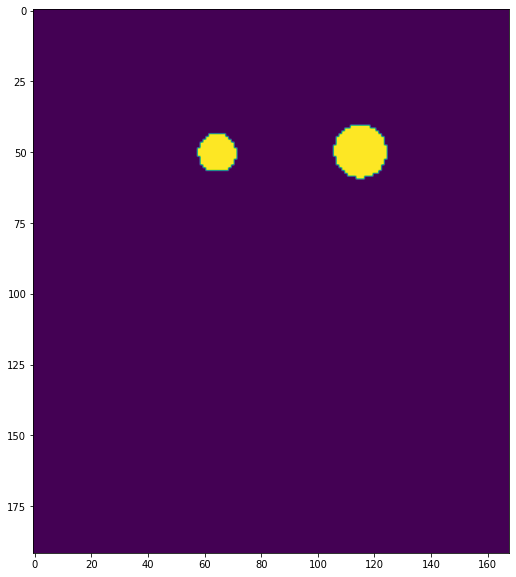

train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


In [12]:
cut_full_res_dataset.set_output_label([OARS_LABELS.EYE_L, OARS_LABELS.EYE_R, OARS_LABELS.LENS_L, OARS_LABELS.LENS_R])
plt.figure(figsize=(10, 10))
plt.imshow(cut_full_res_dataset.__getitem__(0)[1][47])
plt.show()

cut_split_dataset_obj = copy_split_dataset(cut_full_res_dataset, low_res_split_dataset_obj)
get_dataset_info(cut_full_res_dataset, cut_split_dataset_obj)

cut_train_dataset, cut_valid_dataset, cut_test_dataset = itemgetter(
    'train_dataset', 'valid_dataset', 'test_dataset')(cut_split_dataset_obj)

## Training Cut Model

In [13]:
cut_model_info = prepare_model(epochs=30,
                               learning_rate=5e-4,
                               in_channels=8,
                               batch_size=2,
                               train_dataset=cut_train_dataset, valid_dataset=cut_valid_dataset, test_dataset=cut_test_dataset)
show_model_info(cut_model_info)

cut_train_loop_params = {k:v for k,v in cut_model_info.items() if k not in ['model_total_params', 'model_total_trainable_params']}
train_loop(**cut_train_loop_params)

Device running "cuda"
max output channels 128
Model number of params: 1193537, trainable 1193537
Running training loop
Batch train [1] loss 0.99691, dsc 0.00620
Batch train [2] loss 0.99554, dsc 0.00871
Batch train [3] loss 0.99431, dsc 0.01091
Batch train [4] loss 0.99307, dsc 0.01358
Batch train [5] loss 0.99542, dsc 0.00900
Batch train [6] loss 0.99140, dsc 0.01682
Batch train [7] loss 0.99277, dsc 0.01335
Batch train [8] loss 0.99259, dsc 0.01263
Batch train [9] loss 0.99229, dsc 0.01480
Batch train [10] loss 0.99329, dsc 0.01296
Batch train [11] loss 0.99160, dsc 0.01431
Batch train [12] loss 0.99250, dsc 0.01219
Batch train [13] loss 0.99149, dsc 0.01673
Batch train [14] loss 0.98967, dsc 0.01788
Batch train [15] loss 0.99201, dsc 0.01287
Batch train [16] loss 0.99006, dsc 0.01981
Batch train [17] loss 0.99132, dsc 0.01495
Batch train [18] loss 0.99109, dsc 0.01581
Batch train [19] loss 0.99048, dsc 0.01492
Batch train [20] loss 0.99230, dsc 0.01247
Epoch [1] train done
Batch eva

In [14]:
show_cuda_usage()

CUDA Memory Usage
GPU:        GeForce RTX 2070
Allocated:  0.0 GB
Cached:     0.9 GB
Max memory: 5.1 GB
Max Cached: 6.0 GB


160x128x128 = 2_621_440 \
72x198x168 = 2_395_008

## Cut Model evaluation

(<IPython.core.display.Markdown object>,)

showing number 31
loss 0.9662920236587524, dsc 0.033707957714796066, inputs_len 1


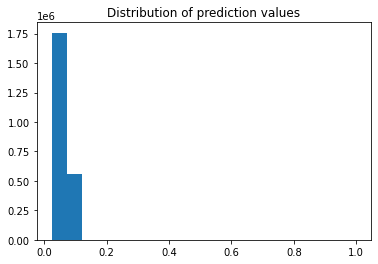

Output()

DEBUG shapes torch.Size([1, 72, 192, 168]) torch.Size([1, 72, 192, 168]) torch.Size([1, 1, 72, 192, 168])
DEBUG prediction max 0.9999998807907104, min 0.024152379482984543
DEBUG intersection 2401.641845703125
DEBUG label sum 3871.0
DEBUG prediction sum 138626.015625
DEBUG intersection2 2401.641845703125
DEBUG dsc 0.033707961440086365
DEBUG MSE 0.00416009034961462


In [15]:
max_slices = cut_train_dataset.__getitem__(0)[1].shape[0]

display((Markdown("### Train Eval"),))
show_model_dataset_pred_preview(cut_model_info, cut_train_dataset, max_slices=max_slices, default_slice=49)

# display((Markdown("### Valid Eval"),))
# show_model_dataset_pred_preview(cut_model_info, cut_valid_dataset, max_slices=max_slices, default_slice=53)

# display((Markdown("### Test Eval"),))
# eval_image_dataset(test_dataset, 78, 'test_plot.png')

### Showing label prediction comparision

In [18]:
preds, rescaled_preds = get_rescaled_preds(cut_model_info["model"], cut_full_res_dataset, cut_model_info["device"])

In [125]:
compare_prediction_with_ground_true(cut_full_res_dataset, rescaled_preds, dataset_index=0, default_slice=49)

Output()